# Wikipedia pageviews API: OJ Simpson

#### Import Python tools and Jupyter configuration

In [1]:
import us
import json
import requests
import pageviewapi
import pandas as pd
import jupyter_black
import altair as alt
import datetime as dt
import altair_cnn as altcnn
from tqdm.notebook import tqdm, trange
from IPython.display import Image

In [2]:
alt.themes.register("cnn", altcnn.theme)
alt.themes.enable("cnn")

ThemeRegistry.enable('cnn')

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [4]:
begin = "20100101"
today = dt.datetime.today().strftime("%Y%m%d")
now = dt.datetime.today().strftime("%Y-%m-%d_%H:%M:%S")

In [5]:
then = pd.to_datetime("2021-01-01")
today_date = pd.to_datetime(dt.datetime.today().strftime("%Y-%m-%d"))
days_difference = (today_date - then).days

---

## Fetch

#### Pull daily pageviews of [OJ's wikipedia page](https://en.wikipedia.org/wiki/O._J._Simpson) using the wikipedia API

In [6]:
slug = 'O._J._Simpson'

In [7]:
def fetch_views(slug, begin, today):
    try:
        response = pageviewapi.per_article(
            'en.wikipedia', slug, begin, today,
            access='all-access', agent='all-agents', granularity='daily'
        )

        items = response['items']
        df = pd.DataFrame(items)
        return df

    except pageviewapi.client.ZeroOrDataNotLoadedException as e:
        logger.info(f"No data available for {slug} from {begin} to {today}: {e}")
        return pd.DataFrame()

#### Use the function to fetch data

In [8]:
views_df = fetch_views(slug, begin, today)

In [9]:
views_df['date'] = pd.to_datetime(views_df['timestamp'].str[:8])

In [ ]:
views_df.sort_values('date', ascending=False).head()

In [50]:
views_df.query('date != "2024-04-11"')

/var/folders/k0/l0l0k9f50w7cg_phqmhkhybm0000gx/T/ipykernel_40296/1868107469.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  views_df.query('date != "2024-04-11"')


,project,article,granularity,timestamp,access,agent,views,date
0,en.wikipedia,O._J._Simpson,daily,2015070100,all-access,all-agents,6785,2015-07-01
1,en.wikipedia,O._J._Simpson,daily,2015070200,all-access,all-agents,7713,2015-07-02
2,en.wikipedia,O._J._Simpson,daily,2015070300,all-access,all-agents,9028,2015-07-03
3,en.wikipedia,O._J._Simpson,daily,2015070400,all-access,all-agents,6643,2015-07-04
4,en.wikipedia,O._J._Simpson,daily,2015070500,all-access,all-agents,6656,2015-07-05
...,...,...,...,...,...,...,...,...
3202,en.wikipedia,O._J._Simpson,daily,2024040600,all-access,all-agents,7605,2024-04-06
3203,en.wikipedia,O._J._Simpson,daily,2024040700,all-access,all-agents,8830,2024-04-07
3204,en.wikipedia,O._J._Simpson,daily,2024040800,all-access,all-agents,7476,2024-04-08
3205,en.wikipedia,O._J._Simpson,daily,2024040900,all-access,all-agents,7473,2024-04-09


In [11]:
def fetch_edit_counts(slug, start_date, end_date):
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "prop": "revisions",
        "titles": slug,
        "rvslots": "main",
        "rvlimit": "500",
        "rvprop": "timestamp",
        "rvdir": "newer",
        "rvstart": start_date + "T00:00:00Z",
        "rvend": end_date + "T23:59:59Z",
        "formatversion": "2",
        "format": "json"
    }

    timestamps = []

    while True:
        response = S.get(url=URL, params=PARAMS)
        data = response.json()

        if 'query' in data:
            pages = data['query']['pages'][0]
            if 'revisions' in pages:
                revisions = pages['revisions']
                timestamps.extend([rev['timestamp'] for rev in revisions])
            else:
                print("No revisions found for the given parameters.")
                break
        else:
            print("Error in fetching data. API Response:", data)
            break
        
        if 'continue' not in data:
            break
        else:
            PARAMS['rvcontinue'] = data['continue']['rvcontinue']

    if timestamps:
        df = pd.DataFrame(timestamps, columns=['timestamp'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['count'] = 1
        edit_counts = df.groupby(df['timestamp'].dt.date).count()
    else:
        edit_counts = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
        edit_counts['count'] = 0  # Initialize edit counts to 0

    return edit_counts

#### Get edit counts

In [12]:
slug = "O._J._Simpson"
start_date = "2000-01-01"
end_date = "2024-04-31"
edit_counts = fetch_edit_counts(slug, start_date, end_date)

In [13]:
edits_df = edit_counts.drop('timestamp', axis=1).reset_index()

In [14]:
edits_df['timestamp'] = pd.to_datetime(edits_df['timestamp'])

#### Edit details

In [15]:
def fetch_edit_details(slug, start_date, end_date):
    session = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "prop": "revisions",
        "titles": slug,
        "rvslots": "main",
        "rvprop": "timestamp|user|userid|size|comment",
        "rvlimit": "500",
        "rvdir": "newer",
        "rvstart": start_date + "T00:00:00Z",
        "rvend": end_date + "T23:59:59Z",
        "formatversion": "2",
        "format": "json"
    }

    revisions = []

    while True:
        response = session.get(url=URL, params=PARAMS)
        data = response.json()

        if 'query' in data:
            pages = data['query']['pages'][0]
            if 'revisions' in pages:
                revs = pages['revisions']
                revisions.extend([{
                    'timestamp': rev['timestamp'],
                    'user': rev['user'],
                    'userid': rev['userid'],
                    'size': rev.get('size', 0),
                    'comment': rev.get('comment', '')
                } for rev in revs])
            else:
                print("No more revisions found.")
                break
        else:
            print("Error fetching data:", data)
            break

        if 'continue' not in data:
            break
        else:
            PARAMS['rvcontinue'] = data['continue']['rvcontinue']

    df = pd.DataFrame(revisions)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

#### Get edit details

In [16]:
slug = "O._J._Simpson"
start_date = "2021-01-01"
end_date = "2024-04-31"
details_df = fetch_edit_details(slug, start_date, end_date).sort_values('timestamp', ascending=False)

In [17]:
details_df['timestamp'] = pd.to_datetime(details_df['timestamp'])
details_df['date'] = details_df['timestamp'].dt.date

In [18]:
len(details_df.query('date == date.max()'))

135

In [19]:
details_df.query('date == date.max()').tail(1).iloc[0]

timestamp    2024-04-12 00:29:11+00:00
user                          Sekhemty
userid                        41376680
size                            145426
comment                               
date                        2024-04-12
Name: 433, dtype: object

---

## Charts

### Views

In [20]:
views_chart = alt.Chart(views_df).mark_bar().encode(
    x=alt.X('date', axis=alt.Axis(format='%b %Y'), title=''),
    y=alt.Y('views', title='', axis=alt.Axis(tickCount=4, format='.0s'))
).properties(title='Daily views of O.J. Simpson\'s wikipedia page', height=350, width=600)

In [21]:
views_chart.save("visuals/views_chart.png")
views_chart.save(f"visuals/views_chart_{now}.png")

In [ ]:
Image(filename="visuals/views_chart.png")

In [51]:
views_df.head()

,project,article,granularity,timestamp,access,agent,views,date
0,en.wikipedia,O._J._Simpson,daily,2015070100,all-access,all-agents,6785,2015-07-01
1,en.wikipedia,O._J._Simpson,daily,2015070200,all-access,all-agents,7713,2015-07-02
2,en.wikipedia,O._J._Simpson,daily,2015070300,all-access,all-agents,9028,2015-07-03
3,en.wikipedia,O._J._Simpson,daily,2015070400,all-access,all-agents,6643,2015-07-04
4,en.wikipedia,O._J._Simpson,daily,2015070500,all-access,all-agents,6656,2015-07-05


### Edits

In [ ]:
edits_chart = alt.Chart(edits_df).mark_bar().encode(
    x=alt.X('timestamp', axis=alt.Axis(format='%Y'), title=''),
    y=alt.Y('count', title='', axis=alt.Axis(tickCount=4))
).properties(title='Daily edits of O.J. Simpson\'s wikipedia page', height=350, width=600)

In [ ]:
edits_df['count'].mean()

In [52]:
edits_df

,timestamp,count
0,2003-01-14,1
1,2003-01-25,1
2,2003-02-06,1
3,2003-02-21,1
4,2003-04-27,12
...,...,...
1977,2024-04-02,1
1978,2024-04-06,1
1979,2024-04-09,1
1980,2024-04-11,161


In [33]:
edits_chart.save("visuals/edits_chart.png")
edits_chart.save(f"visuals/edits_chart_{now}.png")

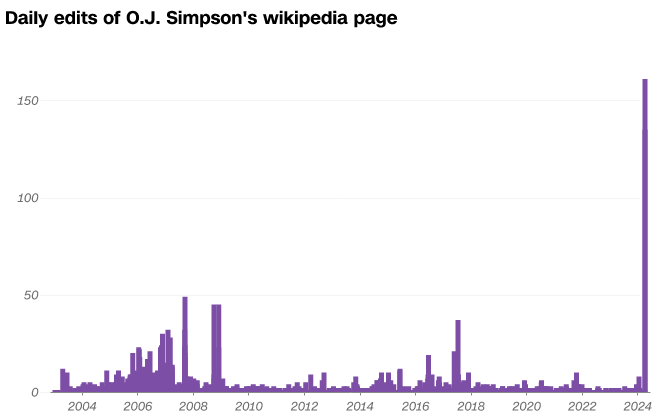

In [34]:
Image(filename="visuals/edits_chart.png")

---

## Exports

### JSON

#### Views

In [26]:
views_df.to_json(
    "data/processed/oj_wiki_pageviews_daily.json", indent=2, orient="records"
)
views_df.to_json(
    f"data/processed/oj_wiki_pageviews_daily_{now}.json", indent=2, orient="records"
)

#### Edit counts

In [27]:
edits_df.to_json(
    "data/processed/oj_wiki_edits_daily.json", indent=2, orient="records"
)
edits_df.to_json(
    f"data/processed/oj_wiki_edits_daily_{now}.json", indent=2, orient="records"
)

#### Edit details

In [28]:
details_df.to_json(
    "data/processed/oj_wiki_edit_details_daily_.json", indent=2, orient="records"
)
details_df.to_json(
    f"data/processed/oj_wiki_edit_details_daily_{now}.json", indent=2, orient="records"
)

### CSV

#### Views

In [29]:
views_df.to_csv("data/processed/oj_wiki_pageviews_daily.csv", index=False)
views_df.to_csv(f"data/processed/oj_wiki_pageviews_daily_{now}.csv", index=False)

#### Edit counts

In [30]:
edits_df.to_csv("data/processed/oj_wiki_edits_daily.csv", index=False)
edits_df.to_csv(f"data/processed/oj_wiki_edits_daily_{now}.csv", index=False)

#### Edit details

In [ ]:
details_df.to_csv("data/processed/oj_wiki_edit_details_daily.csv", index=False)
details_df.to_csv(f"data/processed/oj_wiki_edit_details_daily_{now}.csv", index=False)